In [1]:
%matplotlib inline

import cv2 # OpenCV - to install in Anaconda: $ conda install -c menpo opencv=2.4.11
import pylab as pl
from IPython.display import clear_output, Image

In [2]:
img = cv2.imread('webcam.jpg')
# opencv usually loads images in BGR instead of RGB order
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img.shape

(360, 640, 3)

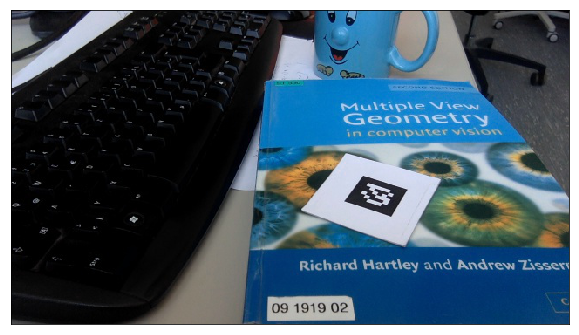

In [3]:
# define a small utility function to show the image using matplotlib
def show_image(img):
    aspect = img.shape[1] / float(img.shape[0])
    s = 10
    figsize = (s, s*aspect) if aspect > 0 else (s*aspect, s)
    pl.figure(figsize=figsize)
    pl.imshow(img, cmap=pl.cm.gray)
    pl.xticks([])
    pl.yticks([])
    
show_image(img)

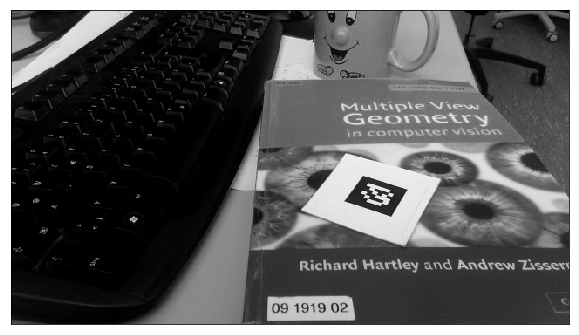

In [4]:
# convert image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
show_image(img_gray)

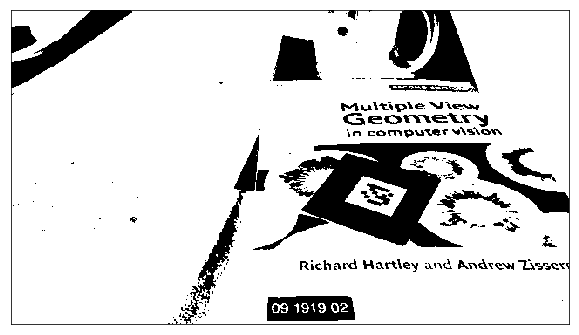

In [5]:
img_bin = img_gray < 128
show_image(img_bin)

In [6]:
# images must be 8bit unsigned integer and from 0 to 255 for OpenCV
img_bin = (img_bin * 255).astype(np.uint8)
# find contours in image - we need to pass a copy since the function modifies the passed image
# and we need img_bin later
contours, hierarchy = cv2.findContours(
    img_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# contours is a list of numpy arrays, each containing 2d point positions
contours[1]

array([[[211, 355]],

       [[212, 354]],

       [[213, 355]],

       [[213, 356]],

       [[212, 357]],

       [[211, 356]]], dtype=int32)

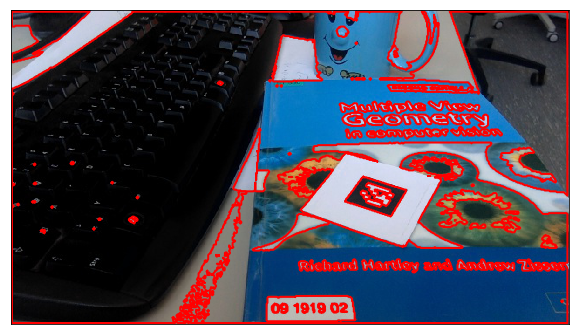

In [7]:
# small utility function that lets us draw the contours
def draw_contours(contours, **kwargs):
    for c in contours:
        c = np.array(c).reshape(len(c), 2)
        pl.plot(c[:, 0], c[:, 1], c='r', lw=2, **kwargs)

show_image(img)
draw_contours(contours)

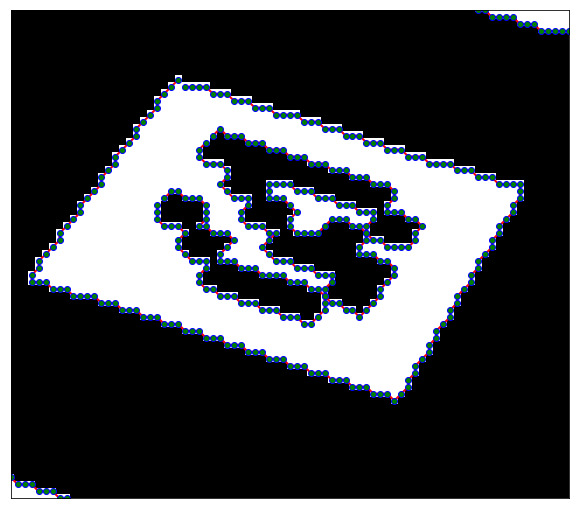

In [8]:
# lets zoom in to see the actual contours
show_image(img_bin)
draw_contours(contours, marker='o', 
              markerfacecolor='g', markeredgecolor='b')
pl.xlim(380, 460)
pl.ylim(250, 180)
pl.show()

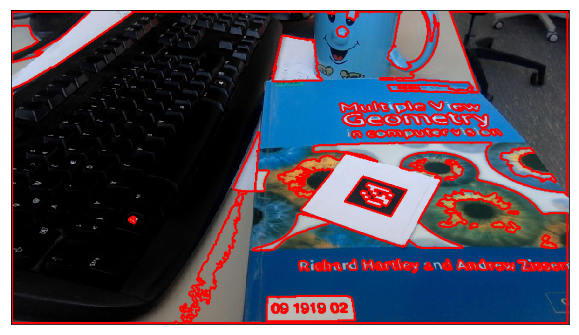

In [9]:
# remove too small contours
min_num_points = 20
contours_filtered = [c for c in contours if len(c) > min_num_points]

show_image(img)
draw_contours(contours_filtered)

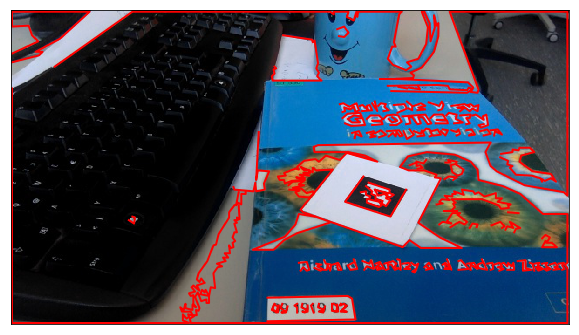

In [10]:
# approximate contours with very few points
# using the Ramer–Douglas–Peucker algorithm
contours_approx = [cv2.approxPolyDP(c, 2, True) 
                   for c in contours_filtered]

show_image(img)
draw_contours(contours_approx)

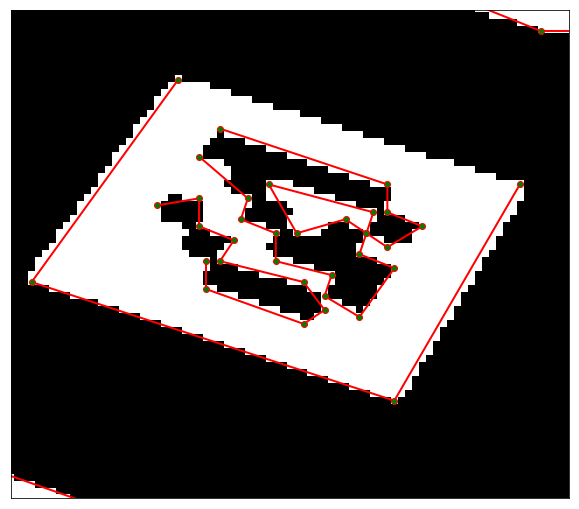

In [11]:
# lets zoom in to see the actual contours now
show_image(img_bin)
draw_contours(contours_approx, marker='o', markerfacecolor='g')
pl.xlim(380, 460)
pl.ylim(250, 180)
pl.show()

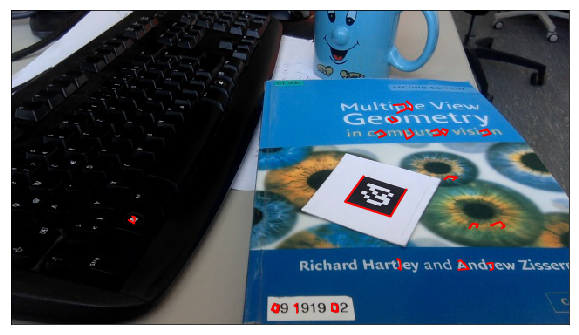

In [12]:
# only accept quads (contours with 4 points)
quads = [c for c in contours_approx if len(c) == 4]

show_image(img)
draw_contours(quads)

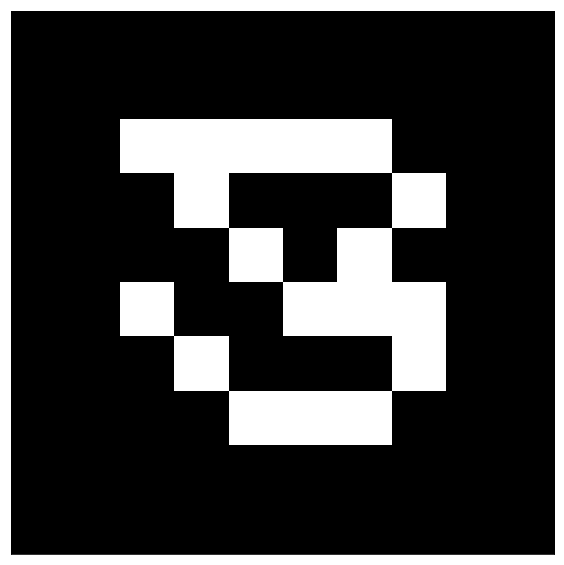

In [13]:
# which quad is the marker? lets compare it to the reference
marker = cv2.cvtColor(cv2.imread("marker.png"), cv2.COLOR_BGR2GRAY)
# upscale marker by factor of 4, so each pixels becomes 4x4 pixels
marker = cv2.resize(marker, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
marker_width, marker_height = marker.shape[1], marker.shape[0]
show_image(marker)

---
# Estimating a Homography

To compare the detected marker with the known marker image we need to warp the quad in the webcam image. To do this we have to estimate a so-called homography. For this, we need some basics...

In [14]:
# define points on the 2D marker
points_plane = np.array([
    (0, 0),
    (0, marker_height),
    (marker_width, marker_height),
    (marker_width, 0),
], np.float)
# find the 3x3 matrix H - our homography
H, _ = cv2.findHomography(quads[12].reshape(-1, 2).astype(np.float), 
                          points_plane)
H

array([[  1.13043569e+00,   8.18591364e-01,  -6.12228379e+02],
       [ -6.09547590e-01,   1.99118879e+00,  -1.32068645e+02],
       [ -2.43985237e-04,   3.91356487e-03,   1.00000000e+00]])

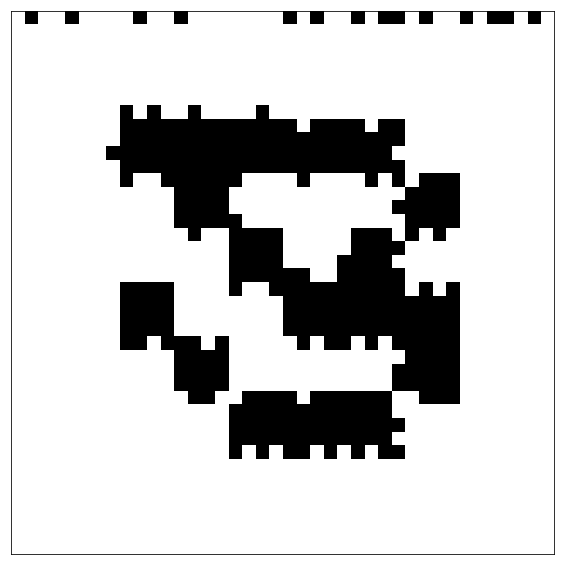

In [15]:
# deform the image according to this homography
unwarped = cv2.warpPerspective(
    img_bin, H, 
    (marker_width, marker_height), 
    flags=cv2.INTER_NEAREST)
show_image(unwarped)

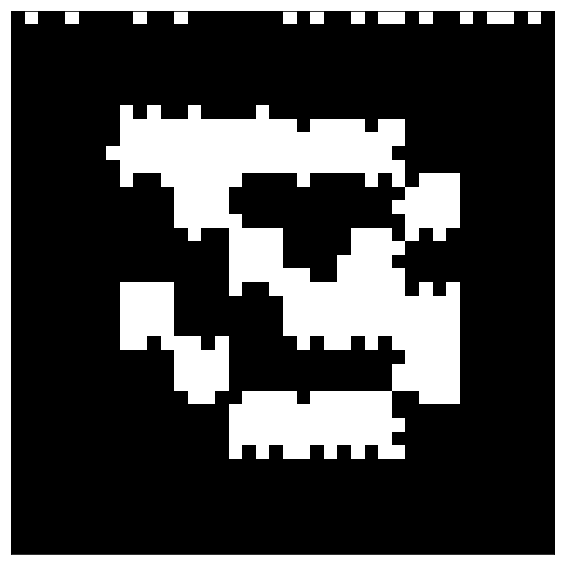

In [16]:
# need to invert the image
unwarped = 255 - unwarped
show_image(unwarped)

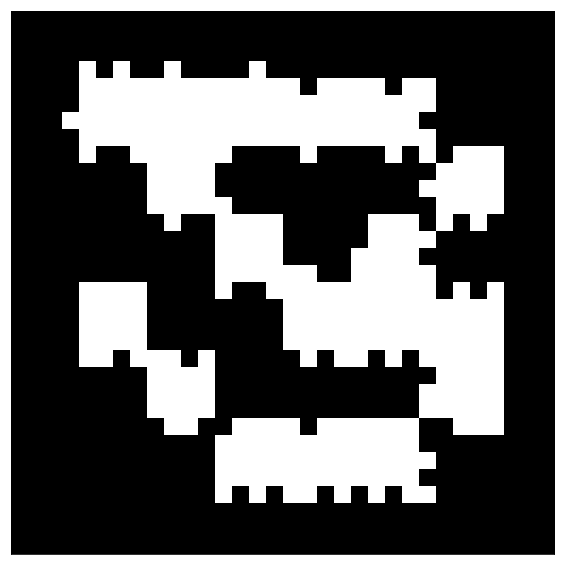

In [17]:
# cut border
border = 4
unwarped_cropped = unwarped[border:-border, border:-border]
marker_cropped = marker[border:-border, border:-border]
show_image(unwarped_cropped)

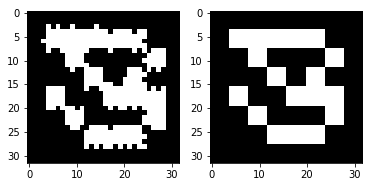

In [18]:
pl.subplot(121)
pl.imshow(unwarped_cropped, cmap=pl.cm.gray)
pl.subplot(122)
pl.imshow(marker_cropped, cmap=pl.cm.gray)
pl.show()

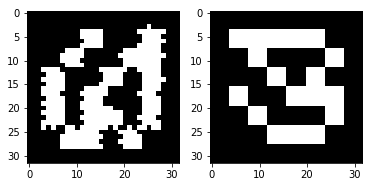

In [19]:
# it might also be that the marker is rotated in the image ... we do not know
pl.subplot(121)
pl.imshow(np.rot90(unwarped_cropped, 3), cmap=pl.cm.gray)
pl.subplot(122)
pl.imshow(marker_cropped, cmap=pl.cm.gray)
pl.show()

In [20]:
# systematically test all possible rotations and compute the overlap to the known marker
for rot in xrange(4):
    rotated = np.rot90(unwarped_cropped, rot)
    overlap = (rotated == marker_cropped).mean()
    print("rotation %d: overlap=%.5f%%" % (rot, overlap * 100))

rotation 0: overlap=93.26172%
rotation 1: overlap=66.89453%
rotation 2: overlap=67.48047%
rotation 3: overlap=66.30859%
